## Chapter 5 - Support Vector Machines
---

* **1. What is the fundamental idea behind Support Vector Machines?**
> The idea behind SVMs is that they create decision boundaries between classes based not on the data as a whole, but on the most extreme members of each class, creating the widest possible 'road' between the classes. Using the most extreme data points can cause overfitting however dependent on the dataset, so SVM models include a hyperparameter C which allows a certain amount of the points to be ignored, making the model less complex but more likely to generalise well to unseen data. The book also states the importance of using kernels such as `poly` when training on nonlinear datasets.

* **2. What is a support vector?**
> A support vector is the instance in a training set used to set the decision boundary; only data points within or on the border of the aforementioned 'road' between the classes will be considered in this process, adding more data to the bulk of the class outside of the 'road' will have no effect whatsoever.

* **3. Why is it important to scale the inputs when using SVMs?**
> Using features not of a similar scale can result in the SVM ignoring smaller features, which can be seen from the fact that having non-scaled features results in a narrower 'road' between the classes.

* **4. Can an SVM classifier output a confidence score when it classifies an instance? What about a probability?**
> The SVM cannot directly output a probability when it performs classification. Using the distance of a point from the decision boundary it is however possible to give a confidence score however, much like with other classifiers.

* **5. Should you use the primal or the dual form of the SVM problem to train a model on a training set with millions of instances and hundreds of features?**
> The primal form. Whilst the primal and dual form will return the same solution, the primal form is faster to compute unless the number of features is larger than the number of instances.

* **6. Say you trained an SVM classifier with an RBF kernel. It seems to underfit the training set: should you increase or decrease γ (gamma)? What about C?**
> C and γ should both be increased, as doing so decreases the amount of regularization constraining the model, increasing the model complexity and allowing the model to better fit the training data.

* **7. How should you set the QP parameters (H, f, A, and b) to solve the soft margin linear SVM classifier problem using an off-the-shelf QP solver?**
> For the hard margin problem there are $n_p = n+1$ parameters (where $n$ is the number of features and the extra parameter is due to the bias term) and $n_c = m$ constraints (where $m$ is the number of training instances). $H$ is a $n_p \times n_p$ identity matrix but with a zero in the upper left element so as to ignore the bias term in the input. $F$ is a vector filled with zeroes, with the same number of dimensions as the weight vector $w$, $n_p$. $b$ must be an $n_c$ dimensional vector filled only with 1s and finally $a^i = -t^i \dot{x}^i $. <br><br>
For the soft margin problem (these parameters will be denoted with *), now the number of parameters increases by $m$, becoming $n_p^* = n+1+m$, and similarly the number of constraints increases by $m$, becoming $n_c^*=2m$. $H^*$ is an $(m+1) \times (m+1)$ matrix full of zeroes, apart from the upper left element which is equal to $H$. $F^*$ is the same as $F$, just with $m$ extra elements, all filled with the value of the `C` regularization hyperparameter. Similarly, $b^*$ is equal to $b$ just with $m$ extra elements, except this time the extra elements are all zeroes. Finally: $ A^* = \begin{bmatrix} A & I_m \\ 0 & -I_m \end{bmatrix}$ where $I_m$ is an $m \times m$ identity matrix.

* **8. Train a LinearSVC on a linearly separable dataset. Then train an SVC and a SGDClassifier on the same dataset. See if you can get them to produce roughly the same model.**

Firstly we'll load in the data, scale it using a standardised scaler and then train the Linear SVC, SVC and SGDClassifiers. As the book has, I've used the Iris dataset (specifically petal length and width for Iris-Virginica) since it's easily linearly separable.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import datasets
plt.style.use('dark_background')

iris = datasets.load_iris()
X = iris['data'][:, (2, 3)]
y = (iris['target'] == 2).astype(np.float64)

linear_svc = Pipeline((
            ('scaler', StandardScaler()),
            ('svc', LinearSVC(C=3, loss='hinge')),
            ))

svc = Pipeline((
            ('scaler', StandardScaler()),
            ('svc', SVC(kernel='linear', C=2)),
            ))

sgd = Pipeline((
            ('scaler', StandardScaler()),
            ('svc', SGDClassifier(loss='hinge', tol=0.0001, penalty='elasticnet', 
                                  alpha=0.01, l1_ratio=0.5)),
            ))

linear_svc.fit(X, y)
svc.fit(X, y)
sgd.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SGDClassifier(alpha=0.01, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.5, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
       power_t=0.5, random_state=None, shuffle=True, tol=0.0001,
       validation_fraction=0.1, verbose=0, warm_start=False))])

After fitting the three models, we can now plot the decision boundaries using a meshgrid to visualise just how similar the classifiers are after tuning them to make them behave as similarly as possible.

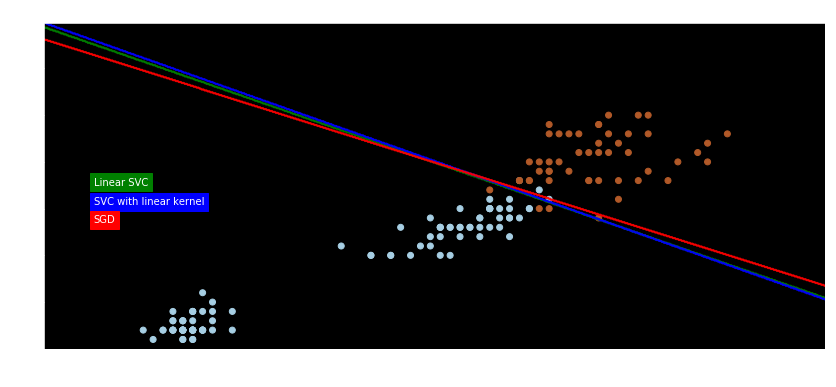

In [2]:
h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

labels = ['Linear SVC', 'SVC with linear kernel', 'SGD']
colors = ['g', 'b', 'r']
plt.figure(figsize=(14, 6))

for i, clf in enumerate([linear_svc, svc, sgd]):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors=colors[i], alpha=0.4)

plt.annotate(labels[0], (0.5, 1.75), backgroundcolor='g')
plt.annotate(labels[1], (0.5, 1.54), backgroundcolor='b')
plt.annotate(labels[2], (0.5, 1.35), backgroundcolor='r')

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(0, xx.max())
plt.ylim(0, yy.max())
plt.title('Iris Classifier Comparison')
plt.show()

By testing out a few different selections of hyperparameters, I managed to find a combination which resulted in all three models returning a very similar decision boundary, as can be seen above.

* **9. Train an SVM classifier on the MNIST dataset. Since SVM classifiers are binary classifiers, you will need to use one-versus-all to classify all 10 digits. You may want to tune the hyperparameters using small validation sets to speed up the process. What accuracy can you reach?**

Firstly, as previously we need to load the MNIST dataset, split it into the predefined training and test sets and then shuffle the training set to avoid blocks of the same numbers within the training set.

In [3]:
from sklearn.datasets import fetch_openml

np.random.seed(42)                                                               # makes notebook output reproducible across runs

def sort_by_target(mnist):                                                       # function is required as 'fetch_openml returns' the unsorted MNIST data
    reorder_train = np.array(sorted([(target, i) for i, target in \
                                     enumerate(mnist.target[:60000])]))[:, 1]    # 'sort_by_target' makes the dataset the same as is used in the book
    reorder_test = np.array(sorted([(target, i) for i, target in  \
                                     enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]
    
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8)                                      # fetch_openml() returns targets as strings
sort_by_target(mnist)                                                            # fetch_openml() returns an unsorted dataset

X, y = mnist["data"], mnist["target"]
print('Shape of MNIST data: ', X.shape)
print('Shape of MNIST target data: ', y.shape)

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

Shape of MNIST data:  (70000, 784)
Shape of MNIST target data:  (70000,)


Now we have the data ready to feed into a model, we can build the One vs All (`'ovr'`) SVC. Training this will likely be a timely process due to having to train 10 different classifiers on the whole training set; each one will attempt to determine whether a given digit is for example a 2, or not, hence 10 separate binary classifiers are required.

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score

ovr_clf = OneVsRestClassifier(SVC(kernel='linear', C=2))
ovr_clf.fit(X_train, y_train)
cv_scores = cross_val_score(ovr_clf, X_train, y_train, cv=3,
                           scoring='accuracy')

print(cv_scores)

######## RUN ##########################

* **10. Train an SVM regressor on the California housing dataset.** 

Already did this as part of Chapter 2, Exercise 4 where I used the SVR (Support Vector Regressor) from scikit-learn as part of a preparation and prediction pipeline.